<a href="https://colab.research.google.com/github/Subinhyun/AI/blob/master/Titanic_%EC%83%9D%EC%A1%B4%EC%9E%90_%EC%98%88%EC%B8%A1_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic 생존자 예측
### 타이타닉 호 침몰 사건 당시의 사망자와 생존자를 구분하는 요인 분석을 통해, 승객들의 생존 여부를 예측

### 필요한 라이브러리 설치

In [38]:
# 데이터 불러오기
import pandas as pd
import numpy as np
import random as rnd

In [39]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# 머신러닝
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [41]:
import warnings
warnings.filterwarnings(action='ignore')

### 데이터 셋 불러오기
###### - train.csv : 모델 학습에 사용되는 데이터
###### - test.csv : 모델 적용 대상이 되는 데이터

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
train_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/인공지능/titanic/train.csv")
test_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/인공지능/titanic/test.csv")
# 모델 적용의 일관성을 위해,
# train과 test를 합한 combine 데이터 셋도 지정
combine=[train_df,test_df]

### 데이터 변수(Feature) 확인

In [44]:
# 변수 보기
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


##### 변수설명
PassengerId : 각 승객의 고유 번호

Survived : 생존 여부(종속 변수)
+ 0 = 사망
+ 1 = 생존

Pclass : 객실 등급 - 승객의 사회적, 경제적 지위
+ 1st = Upper
+ 2nd = Middle
+ 3rd = Lower

Name : 이름

Sex : 성별

Age : 나이

SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수

Parch : 동반한 Parent(부모) Child(자식)의 수

Ticket : 티켓의 고유넘버

Fare : 티켓의 요금

Cabin : 객실 번호

Embarked : 승선한 항
+ C = Cherbourg
+ Q = Queenstown
+ S = Southampton

In [45]:
# 데이터 미리 보기
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


예측의 대상인 object 변수(Label)은 "Survived", 나머지는 설명 변수로 작용됨

In [46]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [47]:
# 훈련 자료 정보
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [48]:
# 테스트 자료 정보
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 데이터 분석

In [49]:
# 훈련 자료 int, float 변수 통계치
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


+ 훈련 자료 샘플 수 : 891 (count=891)
+ 훈련 자료 샘플 내 생존율 : 38.4% (mean의 Survived=0.383838)

In [50]:
# 훈련 자료 object 변수 통계치
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Scanlan, Mr. James",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


+ 훈련 자료 남성 수 : 577명 (top의 Sex = male, freq의 Sex = 577)
+ 훈련 자료 가장 많은 승선지 : S, 644명 (top의 Embarked = S, freq의 Emabarked =644)

### 훈련 자료에서 객실 등급(Pclass)에 따른 생존율 비교

In [51]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#groupby에 as_index를 False로 하면 Pclass를 index로 사용하지 않음
# ascending : 오름차순
# as_index를 True로 하면 Pclass를 index로 사용

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


+ 객실 등급이 좋을 수록 생존율이 높음

### 훈련 자료에서 성별(Sex)에 따른 생존율 비교

In [52]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


+ 여성의 생존율이 남성보다 높음

### 훈련 자료에서 함께 승선한 형제자매와 배우자 수(SibSp)에 따른 생존율 비교

In [53]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### 훈련 자료에서 함께 승선한 부모와 자식 수(Parch)에 따른 생존율 비교

In [54]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


+ 동행이 적은 경우, 생존율이 높음

### 훈련 자료에서 생존 여부(Survived)에 따른 연령(Age) 분포

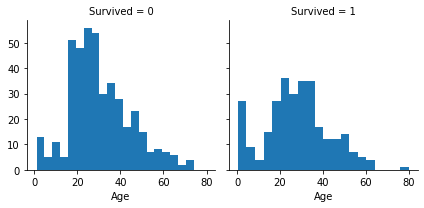

In [55]:
# 열(col)을 생존 여부로 나눔
g = sns.FacetGrid(train_df, col='Survived')
# 히스토그램으로 시각화, 연령의 분포를 확인, 히스토그램 bin을 20개로 설정
g.map(plt.hist, 'Age', bins=20)

+ 4세 이하의 유아의 생존율이 높음
+ 15 ~ 25세 승객들의 생존율이 높음

### 훈련 자료에서 객실 등급(Pclass)과 생존 여부(Survived)에 따른 연령(Age) 분포

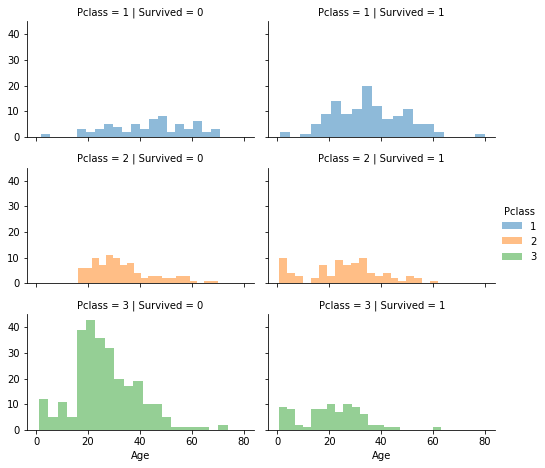

In [56]:
# 열을 생존 여부, 행(row)과 색깔(hue)을 객실 등급으로 나눔, width = height * aspect
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', hue="Pclass", height=2.2, aspect=1.6)

grid.map(plt.hist, 'Age', alpha=.5, bins=20) # 투명도(alpha): 0.5

# 범례 추가
grid.add_legend();

+ 객실 등급이 3등급인 경우, 승객 수는 가장 많고, 생존율도 가장 낮음
+ 객실 등급이 2등급인 유아는 대부분 생존함
+ 객실 등급이 1등급인 경우 생존율이 비교적 높음

### 훈련자료에서 승선지(Embarked)와 객실 등급(Pclass)에 따른 생존율(Survived)

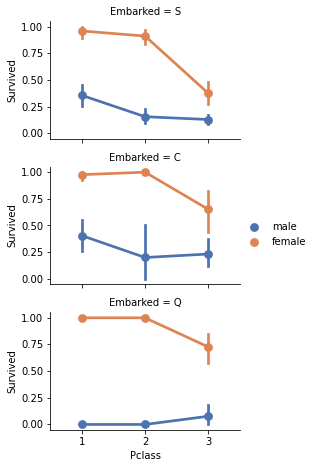

In [57]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)

# Pointplot으로 시각화, x: 객실 등급, y: 생존 여부, 색깔: 성별, x축 순서: [1, 2, 3], 색깔 순서: [남성, 여성]
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order = [1, 2, 3], hue_order = ["male", "female"])

grid.add_legend()

+ 승선지가 C와 Q인 경우, 남성의 티켓 등급이 3등급일 때 2등급보다 생존율이 높을 가능성이 있음

### 훈련 자료에서 승선지(Embarked), 생존 여부(Survived), 성별(Sex)에 따른 요금(Fare)

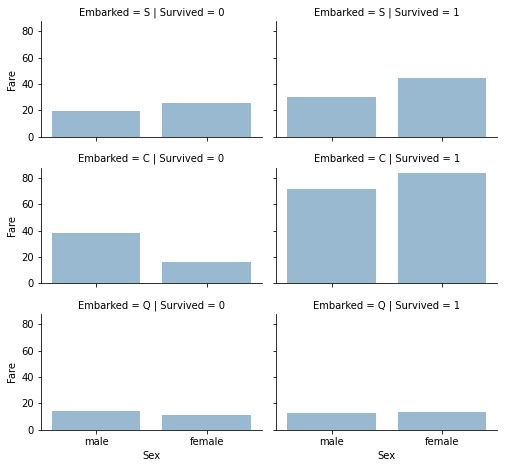

In [58]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)

# 바그래프로 시각화, x: 성별, y: 요금, Error bar: 표시 안 함
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])

grid.add_legend()

+ 승선지가 S또는 C인 경우, 생존한 승객들의 평균 요금이 비교적 높음

## 데이터 전처리

### 안쓸 변수(Ticket, Cabin) 제거

In [59]:
print("Before", train_df.shape, test_df.shape)

# 열(axis=1)제거
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]
print("After", train_df.shape, test_df.shape)

Before (891, 12) (418, 11)
After (891, 10) (418, 9)


In [60]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


+ female에서는 Miss와 Mrs가, male에서는 Master와 Mr가 두드러지게 나타남(Mlle와 Ms 는 Miss의, Ms는 Mrs의 불어식 표현)

+ 나머지는 Rare로 분류

In [61]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Title 변수를 숫자형 변수로 바꿔줌

In [62]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


### 안쓸 변수(Name, PassengerId) 제거

In [63]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### 성별(Sex) 변수를 숫자 범주형 변수로 바꿔줌

In [64]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### 객실 등급(Pclass)과 성별(Sex) 시각화

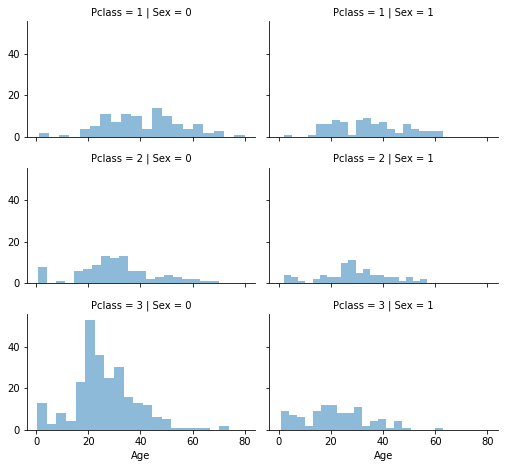

In [65]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

+ Pclass, Sex와 Age와의 결합이 2열 3행으로 구성됨

In [66]:
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            # 위에서 guess_ages사이즈를 [2,3]으로 잡아뒀으므로 j의 범위도 이를 따름
            
            age_guess = guess_df.median()

            # age의 random값의 소수점을 .5에 가깝도록 변형
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
Title       0
dtype: int64

+ Age의 결측치가 채워짐

### 연령(Age) 변수를 범주형 변수로 바꿔줌

In [67]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# 임의로 5개 그룹을 지정
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### AgeBand를 바탕으로 Age를 범주형 변수로 바꿔준 후, AgeBand변수는 제거

In [68]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### SibSp와 Parch를 가족과의 동반여부를 알 수 있는 새로운 변수로 통합

In [69]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


+ FamilySize가 1인 것은 가족과 동반하지 않음을 의미

In [70]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


+ 1은 동반X
+ 0은 동반했다는 새로운 변수 IsAlone을 생성

In [71]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


### Age변수와 Pclass를 곱한 Age*Class변수 생성

In [72]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### 승선지(Ebmarked) 변수를 최빈값으로 대체

In [73]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [74]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### 승선지(Ebmarked) 변수를 범주형 변수로 바꿔줌

In [75]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### 요금(Fare) 변수를 중앙값으로 대체

In [76]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


### 요금(Fare)을 숫자 범주형 변수로 바꿔줌

In [77]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [78]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [79]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


+ 이제 훈련(train) 데이터셋 준비완료

## 데이터 준비

In [80]:
# 목적 변수 제거
X_train = train_df.drop("Survived", axis=1)
#목적 변수 역할
Y_train = train_df["Survived"]
#예측 대상 데이터 셋
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

### Logistic Regression

In [81]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

In [82]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201619
5,Title,0.397888
2,Age,0.287011
4,Embarked,0.261473
6,IsAlone,0.126553
3,Fare,-0.086655
7,Age*Class,-0.311069
0,Pclass,-0.750700


+ 생존 여부 예측에 영향력이 큰 변수는 성별(Sex)

### SVC(Support Vector Machines)

In [83]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.23

### K-NN(K Nearest Neighberhood)

In [84]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

### Gaussian Naive Bayes

In [85]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

### Perceptron

In [86]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.34

### Linear SVC

In [87]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(acc_linear_svc)

79.12


### Stochastic Gradient Descent

In [88]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

73.96

### Decision Tree

In [89]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

### Random Forest

In [90]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

In [91]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.34
0,Support Vector Machines,78.23
6,Stochastic Gradient Decent,73.96
4,Naive Bayes,72.28


In [92]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })